In [3]:
# #@title **Instalar Paquetes**

!pip install open3d
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: flask
    Found existing installation: Flask 3.1.1
    Uni

# Clonar el proyecto

*Nota: No es necesario cargar ningun tipo de informacion, solo se necesita clonar el repositorio del proyecto. Este documento debe trabajarse en colab.*

In [4]:
!git clone https://github.com/nick3153/Depth-Estimation-with-StereoThermal-Images.git
%cd Depth-Estimation-with-StereoThermal-Images

Cloning into 'Depth-Estimation-with-StereoThermal-Images'...
remote: Enumerating objects: 6181, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 6181 (delta 3), reused 7 (delta 1), pack-reused 6170 (from 3)
Receiving objects: 100% (6181/6181), 1.86 GiB | 29.33 MiB/s, done.
Resolving deltas: 100% (73/73), done.
Updating files: 100% (158/158), done.
/content/Depth-Estimation-with-StereoThermal-Images


In [617]:
#@title Librerias necesarias
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import seaborn as sns
import random
import plotly.graph_objects as go
import matplotlib.gridspec as gridspec
sns.set_theme()

In [6]:
#@title Funciones
def normalize(img):
    image = ((img - img.min()) / (img.max() - img.min())) * 255.0
    return image.astype(np.uint8)

def intensity_binding(img, lower_percentile:int=1, upper_percentile:int=99):
    # Calcular los percentiles
    low = np.percentile(img, lower_percentile)
    high = np.percentile(img, upper_percentile)

    # Recortar al rango [low, high]
    img_clipped = np.clip(img, low, high)

    # Normalizar
    img_norm = normalize(img_clipped)

    return img_norm

def apply_CLAHE(img):
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

def bilateral_filtering(img):
    return cv.bilateralFilter(img, d=5, sigmaColor=20, sigmaSpace=15)

def align_contrast(imgL, imgR):
    meanL = np.mean(imgL)
    meanR = np.mean(imgR)

    if meanR < meanL:
      imageR = imgR * (meanL/meanR)
      return imgL, imageR
    elif meanL < meanR:
      imageL = imgL * (meanR/meanL)
      return imageL, imgR

    return imgL, imgR

def preprocess_thermal_images(imgL, imgR, lower_percentile = 1, upper_percentile = 99):
    # Eliminar outlayers
    imageL = intensity_binding(imgL, lower_percentile, upper_percentile)
    imageR = intensity_binding(imgR, lower_percentile, upper_percentile)

    # Ecualizacion del histograma con clahe
    imageL = apply_CLAHE(imageL)
    imageR = apply_CLAHE(imageR)

    # Eliminacion de ruido
    imageL = bilateral_filtering(imageL)
    imageR = bilateral_filtering(imageR)

    # Alinear constrastes
    imageL, imageR = align_contrast(imageL, imageR)

    return imageL.astype(np.uint8), imageR.astype(np.uint8)

# =====================================================
# Funciones del semillero HOCV
# =====================================================

# Graficar mapas de profundidad
def plot_disparitymap(imgL,imgR,disparity_map):
    disparity_map[(disparity_map <= 0)] = 1

    plt.figure(figsize=(16,5))
    plt.subplot(131)
    plt.imshow(imgL, cmap='gray')
    plt.axis('off')
    plt.title("Image Left")

    plt.subplot(132)
    plt.imshow(imgR, cmap='gray')
    plt.axis('off')
    plt.title("Image Right")

    plt.subplot(133)
    plt.imshow(disparity_map, cmap='viridis')
    plt.axis('off')
    plt.colorbar()
    plt.title('Disparity map')

# Graficar mapa de profundidad
def plot_depth_map(depth_map, umbral=2.0, cmap='viridis'):
    """
    Visualiza el mapa de profundidad y el histograma con un espacio visible en el medio.
    """

    depth = np.copy(depth_map)
    depth[depth <= 0] = np.nan
    depth[depth > umbral] = np.nan
    valid_depth = depth[~np.isnan(depth)]


    fig = plt.figure(figsize=(14, 4))
    spec = gridspec.GridSpec(ncols=3, nrows=1, width_ratios=[1, 0.01, 1])


    ax1 = fig.add_subplot(spec[0])
    im = ax1.imshow(depth, cmap="jet_r")
    ax1.set_title("Mapa de profundidad")
    ax1.axis('off')
    cbar = fig.colorbar(im, ax=ax1, shrink=0.8)
    cbar.set_label("Profundidad (m)")


    ax_blank = fig.add_subplot(spec[1])
    ax_blank.axis('off')


    ax2 = fig.add_subplot(spec[2])
    ax2.hist(valid_depth.ravel(), bins=50, color='teal')
    ax2.set_title("Histograma de profundidad")
    ax2.set_xlabel("Profundidad (m)")
    ax2.set_ylabel("Frecuencia")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def show_images(img1, img2, title1, title2):

    print("Image sizes:", img1.shape, "and", img2.shape)
    plt.figure(figsize=(15,9))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title(title1)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title(title2)
    plt.axis('off')
    plt.show()

def draw_epilines_and_points(img1, lines, pts1):
    img_with_epilines = img1.copy()
    color = (255, 0, 0)

    for line, pt1 in zip(lines, pts1):
        x0, y0 = map(int, [0, -line[2] / line[1]])
        x1, y1 = map(int, [img1.shape[1], -(line[2] + line[0] * img1.shape[1]) / line[1]])
        img_with_epilines = cv.line(img_with_epilines, (x0, y0), (x1, y1), color, 1)
        pt1 = (int(pt1[0]), int(pt1[1]))
        img_with_epilines = cv.circle(img_with_epilines, pt1, 5, color, -1)
    return img_with_epilines

def add_epilines_to_rectified_images(imgLeft, imgRight, ptsLeft, ptsRight, h1, h2):
    ptsLeftRtf = cv.perspectiveTransform(np.float32(ptsLeft).reshape(-1, 1, 2), h1).reshape(-1, 2)
    ptsRightRtf = cv.perspectiveTransform(np.float32(ptsRight).reshape(-1, 1, 2), h2).reshape(-1, 2)

    linesLeftRtf = np.zeros((len(ptsLeftRtf), 3))
    linesRightRtf = np.zeros((len(ptsRightRtf), 3))
    linesLeftRtf[:, 1] = -1
    linesRightRtf[:, 1] = -1
    linesLeftRtf[:, 2] = ptsLeftRtf[:, 1]
    linesRightRtf[:, 2] = ptsRightRtf[:, 1]
    imgLeftWithEpilines = draw_epilines_and_points(imgLeft, linesLeftRtf, ptsLeftRtf)
    imgRightWithEpilines = draw_epilines_and_points(imgRight, linesRightRtf, ptsRightRtf)

    return imgLeftWithEpilines, imgRightWithEpilines

def drawlines(img1, img2, lines, pts1, pts2):
    imgLines = img1.copy()
    imgLines1 = img2.copy()
    r, c = imgLines.shape[:2]
    color = (255, 255, 255)


    for line, pt1, pt2 in zip(lines, pts1, pts2):
        x0, y0 = map(int, [0, -line[2] / line[1]])
        x1, y1 = map(int, [c, -(line[2] + line[0] * c) / line[1]])
        imgLines = cv.line(imgLines, (x0, y0), (x1, y1), color, 1)

        pt1 = (int(pt1[0]), int(pt1[1]))
        pt2 = (int(pt2[0]), int(pt2[1]))
        imgLines = cv.circle(imgLines, pt1, 5, color, -1)
        imgLines1 = cv.circle(imgLines1, pt2, 5, color, -1)

    return imgLines

def sacar_keypoints(imageL, imageR):
  sift = cv.xfeatures2d.SIFT_create()
  keyPointsLeft, descriptorsLeft = sift.detectAndCompute(imageL, None)
  keyPointsRight, descriptorsRight = sift.detectAndCompute(imageR, None)

  FLANN_INDEX_KDTREE = 0
  indexParams = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
  searchParams = dict(checks=50)
  flann = cv.FlannBasedMatcher(indexParams, searchParams)

  goodMatches = []
  ptsLeft = []
  ptsRight = []
  matches = flann.knnMatch(descriptorsLeft, descriptorsRight, k=2)

  print(f"Número de coincidencias antes del test de ratio: {len(matches)}")

  for m, n in matches:
      if m.distance < 0.8 * n.distance:
          goodMatches.append(m)
          ptsLeft.append(keyPointsLeft[m.queryIdx].pt)
          ptsRight.append(keyPointsRight[m.trainIdx].pt)

  print(f"Número de buenas coincidencias después del test de ratio: {len(goodMatches)}")
  ptsLeft = np.float32(ptsLeft)
  ptsRight = np.float32(ptsRight)
  F, mask = cv.findFundamentalMat(ptsLeft, ptsRight, cv.FM_LMEDS)
  _, h1, h2 = cv.stereoRectifyUncalibrated(ptsLeft, ptsRight, F, imageL.shape[:2])
  return keyPointsLeft, keyPointsRight, ptsLeft, ptsRight, h1, h2, goodMatches

def desrectificar_imgs_leve_aleatorio(imgL, imgR, max_shift=5, max_perspective=0.002):
    h, w = imgL.shape[:2]

    def get_random_homography():
        # Pequeños desplazamientos aleatorios en los 4 puntos de la imagen
        rand_shift = lambda: np.random.uniform(-max_shift, max_shift)
        rand_persp = lambda: np.random.uniform(-max_perspective, max_perspective)

        src_pts = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
        dst_pts = np.float32([
            [0 + rand_shift(), 0 + rand_shift()],
            [w + rand_shift(), 0 + rand_shift()],
            [w + rand_shift(), h + rand_shift()],
            [0 + rand_shift(), h + rand_shift()]
        ])

        return cv.getPerspectiveTransform(src_pts, dst_pts)

    # Generar homografías aleatorias diferentes para cada imagen
    H_L = get_random_homography()
    H_R = get_random_homography()

    # Aplicar sin cambiar colores, ni interpolar demasiado
    imgL_warp = cv.warpPerspective(imgL, H_L, (w, h), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REFLECT)
    imgR_warp = cv.warpPerspective(imgR, H_R, (w, h), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REFLECT)

    return imgL_warp, imgR_warp

def show_images(img1, img2, title1, title2):

    print("Image sizes:", img1.shape, "and", img2.shape)
    plt.figure(figsize=(15,9))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title(title1)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title(title2)
    plt.axis('off')
    plt.show()

def draw_epilines_and_points(img1, lines, pts1):
    img_with_epilines = img1.copy()
    color = (255, 0, 0)

    for line, pt1 in zip(lines, pts1):
        x0, y0 = map(int, [0, -line[2] / line[1]])
        x1, y1 = map(int, [img1.shape[1], -(line[2] + line[0] * img1.shape[1]) / line[1]])
        img_with_epilines = cv.line(img_with_epilines, (x0, y0), (x1, y1), color, 1)
        pt1 = (int(pt1[0]), int(pt1[1]))
        img_with_epilines = cv.circle(img_with_epilines, pt1, 5, color, -1)
    return img_with_epilines

def add_epilines_to_rectified_images(imgLeft, imgRight, ptsLeft, ptsRight, h1, h2):
    ptsLeftRtf = cv.perspectiveTransform(np.float32(ptsLeft).reshape(-1, 1, 2), h1).reshape(-1, 2)
    ptsRightRtf = cv.perspectiveTransform(np.float32(ptsRight).reshape(-1, 1, 2), h2).reshape(-1, 2)

    linesLeftRtf = np.zeros((len(ptsLeftRtf), 3))
    linesRightRtf = np.zeros((len(ptsRightRtf), 3))
    linesLeftRtf[:, 1] = -1
    linesRightRtf[:, 1] = -1
    linesLeftRtf[:, 2] = ptsLeftRtf[:, 1]
    linesRightRtf[:, 2] = ptsRightRtf[:, 1]
    imgLeftWithEpilines = draw_epilines_and_points(imgLeft, linesLeftRtf, ptsLeftRtf)
    imgRightWithEpilines = draw_epilines_and_points(imgRight, linesRightRtf, ptsRightRtf)

    return imgLeftWithEpilines, imgRightWithEpilines

def drawlines(img1, img2, lines, pts1, pts2):
    imgLines = img1.copy()
    imgLines1 = img2.copy()
    r, c = imgLines.shape[:2]
    color = (255, 255, 255)


    for line, pt1, pt2 in zip(lines, pts1, pts2):
        x0, y0 = map(int, [0, -line[2] / line[1]])
        x1, y1 = map(int, [c, -(line[2] + line[0] * c) / line[1]])
        imgLines = cv.line(imgLines, (x0, y0), (x1, y1), color, 1)

        pt1 = (int(pt1[0]), int(pt1[1]))
        pt2 = (int(pt2[0]), int(pt2[1]))
        imgLines = cv.circle(imgLines, pt1, 5, color, -1)
        imgLines1 = cv.circle(imgLines1, pt2, 5, color, -1)

    return imgLines

def sacar_keypoints(imageL, imageR):
  sift = cv.xfeatures2d.SIFT_create()
  keyPointsLeft, descriptorsLeft = sift.detectAndCompute(imageL, None)
  keyPointsRight, descriptorsRight = sift.detectAndCompute(imageR, None)

  FLANN_INDEX_KDTREE = 0
  indexParams = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
  searchParams = dict(checks=50)
  flann = cv.FlannBasedMatcher(indexParams, searchParams)

  goodMatches = []
  ptsLeft = []
  ptsRight = []
  matches = flann.knnMatch(descriptorsLeft, descriptorsRight, k=2)

  print(f"Número de coincidencias antes del test de ratio: {len(matches)}")

  for m, n in matches:
      if m.distance < 0.8 * n.distance:
          goodMatches.append(m)
          ptsLeft.append(keyPointsLeft[m.queryIdx].pt)
          ptsRight.append(keyPointsRight[m.trainIdx].pt)

  print(f"Número de buenas coincidencias después del test de ratio: {len(goodMatches)}")
  ptsLeft = np.float32(ptsLeft)
  ptsRight = np.float32(ptsRight)
  F, mask = cv.findFundamentalMat(ptsLeft, ptsRight, cv.FM_LMEDS)
  _, h1, h2 = cv.stereoRectifyUncalibrated(ptsLeft, ptsRight, F, imageL.shape[:2])
  return keyPointsLeft, keyPointsRight, ptsLeft, ptsRight, h1, h2, goodMatches

# 1. Exploración de los datos

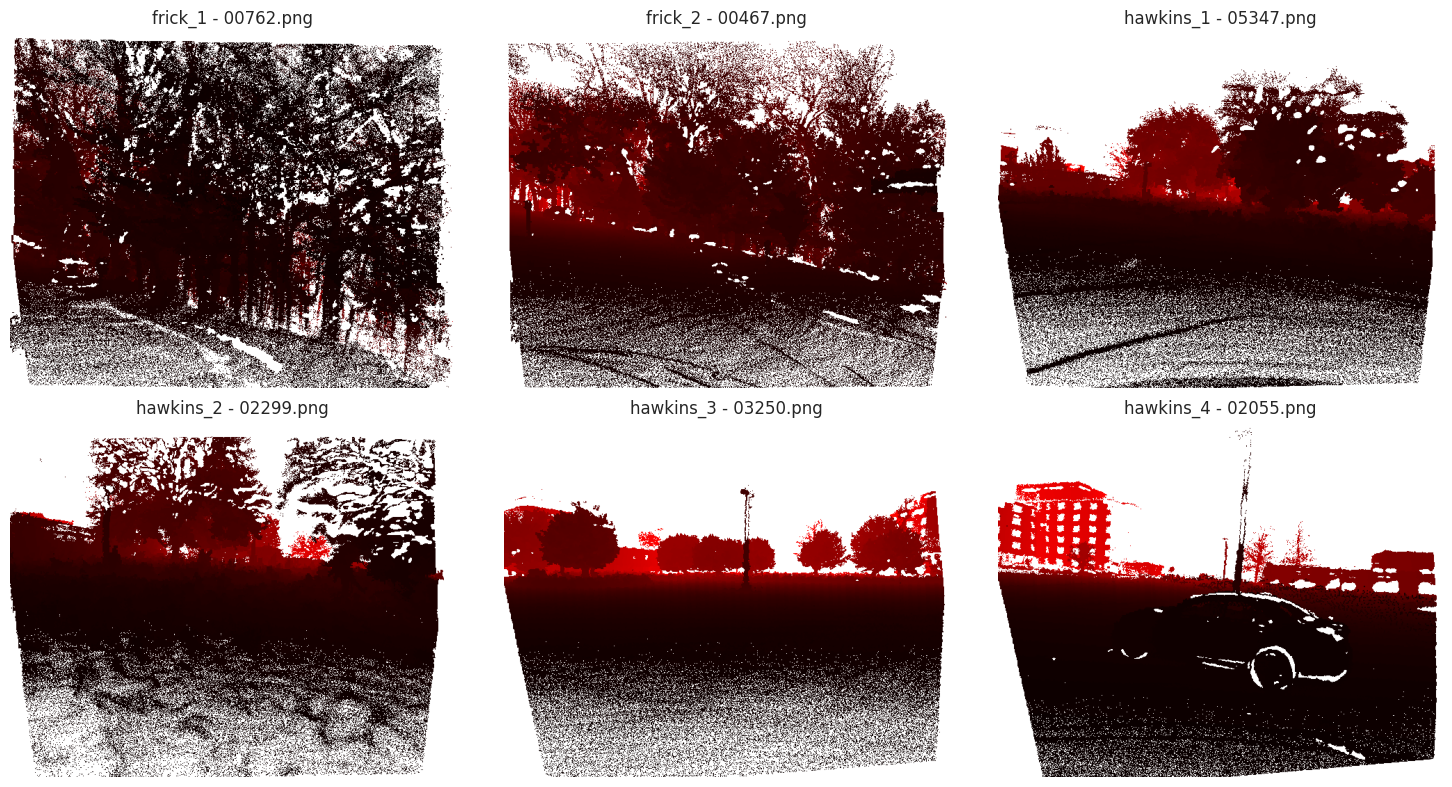

In [605]:
folders_and_images = {
    'frick_1': ['00762.png'],
    'frick_2': ['00467.png'],
    'hawkins_1': ['05347.png'],
    'hawkins_2': ['02299.png'],
    'hawkins_3': ['03250.png'],
    'hawkins_4': ['02055.png'],
}

base_path = '/content/Depth-Estimation-with-StereoThermal-Images/demo_imgs/'

num_folders = len(folders_and_images)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (folder, images) in enumerate(folders_and_images.items()):
    img_path = f"{base_path}{folder}/depth/{images[0]}"
    img = cv.imread(img_path, cv.IMREAD_UNCHANGED)
    img = 1 - img  # Apply the 1 - depth transformation

    axes[i].imshow(img, cmap='hot_r')
    axes[i].set_title(f'{folder} - {images[0]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


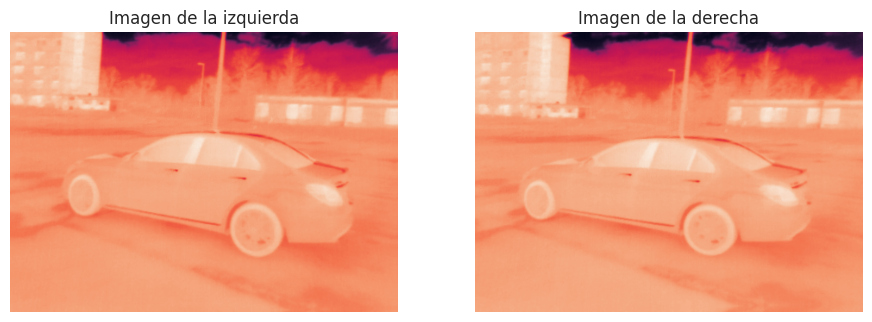

In [572]:
#@title Carga de imagenes termicas
imgs_path = '/content/Depth-Estimation-with-StereoThermal-Images/demo_imgs/hawkins_4/'
image_name = '02055.png'

## Leer imagenes
imgL = cv.imread(imgs_path + f"left/{image_name}", cv.IMREAD_UNCHANGED)[125:450, 100:550]
imgR = cv.imread(imgs_path + f"right/{image_name}", cv.IMREAD_UNCHANGED)[125:450, 100:550]

imgL, imgR = desrectificar_imgs_leve_aleatorio(imgL, imgR, 15, 0.002)

## Graficar/mostrar las imagenes
plt.figure(figsize=[11,7])
plt.subplot(121)
plt.imshow(imgL)
plt.title("Imagen de la izquierda")
plt.axis('off')
plt.subplot(122)
plt.imshow(imgR)
plt.title("Imagen de la derecha")
plt.axis('off')
plt.show()

In [573]:
#@title Caracteristicas de las imagenes

print('--'*30)

print("Imagen izquierda")
print('Profundidad de Bits: ', imgL.dtype)
print("Valor maximo = ", imgL.max(), "Valor minimo = ", imgL.min())
print("Valor promedio =  ", np.mean(imgL))
print('Tamaño: ', imgL.shape)

print("Imagen derecha")
print('Profundidad de Bits: ', imgR.dtype)
print("Valor maximo = ", imgR.max(), "Valor minimo = ", imgR.min())
print("Valor promedio =  ", np.mean(imgR))
print('Tamaño: ', imgR.shape)

print('--'*30)

------------------------------------------------------------
Imagen izquierda
Profundidad de Bits:  uint16
Valor maximo =  22701 Valor minimo =  20898
Valor promedio =   22249.920594871794
Tamaño:  (325, 450)
Imagen derecha
Profundidad de Bits:  uint16
Valor maximo =  22271 Valor minimo =  20304
Valor promedio =   21789.71334017094
Tamaño:  (325, 450)
------------------------------------------------------------


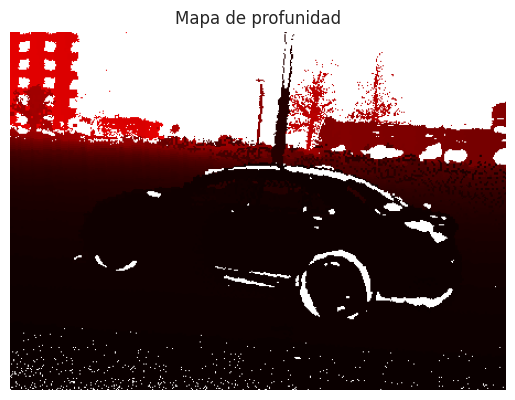

In [574]:
#@title Carga de los mapas de profundidad
## Leer mapas de profundidad
depth = cv.imread(imgs_path + f"depth/{image_name}", cv.IMREAD_UNCHANGED)[125:450, 100:550]
depth = 1 - depth

## Graficar/mostrar los mapas
plt.imshow(depth, cmap='hot_r')
plt.title("Mapa de profunidad")
plt.axis('off')
plt.show()

In [575]:
#@title Caracteristicas de los mapas de pronfidad
print('--'*30)

print("Mapa de profundida")
print('Profundidad de Bits: ', depth.dtype)
print("Valor maximo = ", depth.max(), "Valor minimo = ", depth.min())
print("Valor promedio =  ", np.mean(depth))
print('Tamaño: ', depth.shape)

print('--'*30)

------------------------------------------------------------
Mapa de profundida
Profundidad de Bits:  uint16
Valor maximo =  64784 Valor minimo =  1
Valor promedio =   45681.30326837607
Tamaño:  (325, 450)
------------------------------------------------------------


# 2. Preparación de las imagenes

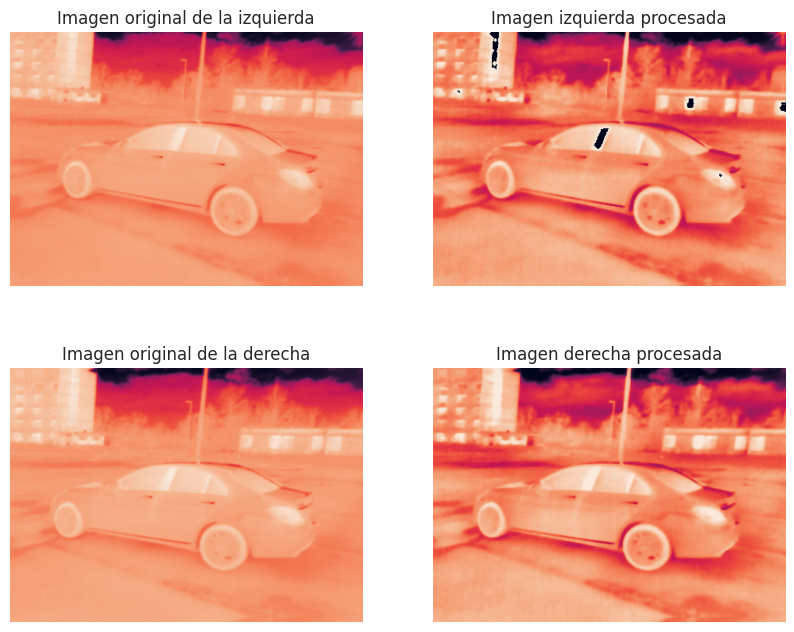

In [576]:
#@title Preprocesado
# Aplicar preprocesado
imageL, imageR = preprocess_thermal_images(imgL, imgR)

plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.imshow(imgL)
plt.title('Imagen original de la izquierda')
plt.axis('off')
plt.subplot(222)
plt.imshow(imageL)
plt.title('Imagen izquierda procesada')
plt.axis('off')
plt.subplot(223)
plt.imshow(imgR)
plt.title('Imagen original de la derecha')
plt.axis('off')
plt.subplot(224)
plt.imshow(imageR)
plt.title('Imagen derecha procesada')
plt.axis('off')
plt.show()

# 3. Calculo de la disparidad y mapa de profundidad


*NOTA: Según el paper, las imagenes estereo termicas del dataset ya se encuentran rectificadas*

**recordar que para este ejemplo de rectificación la imágen se deformó al inicio del notbook**

Número de coincidencias antes del test de ratio: 191
Número de buenas coincidencias después del test de ratio: 87


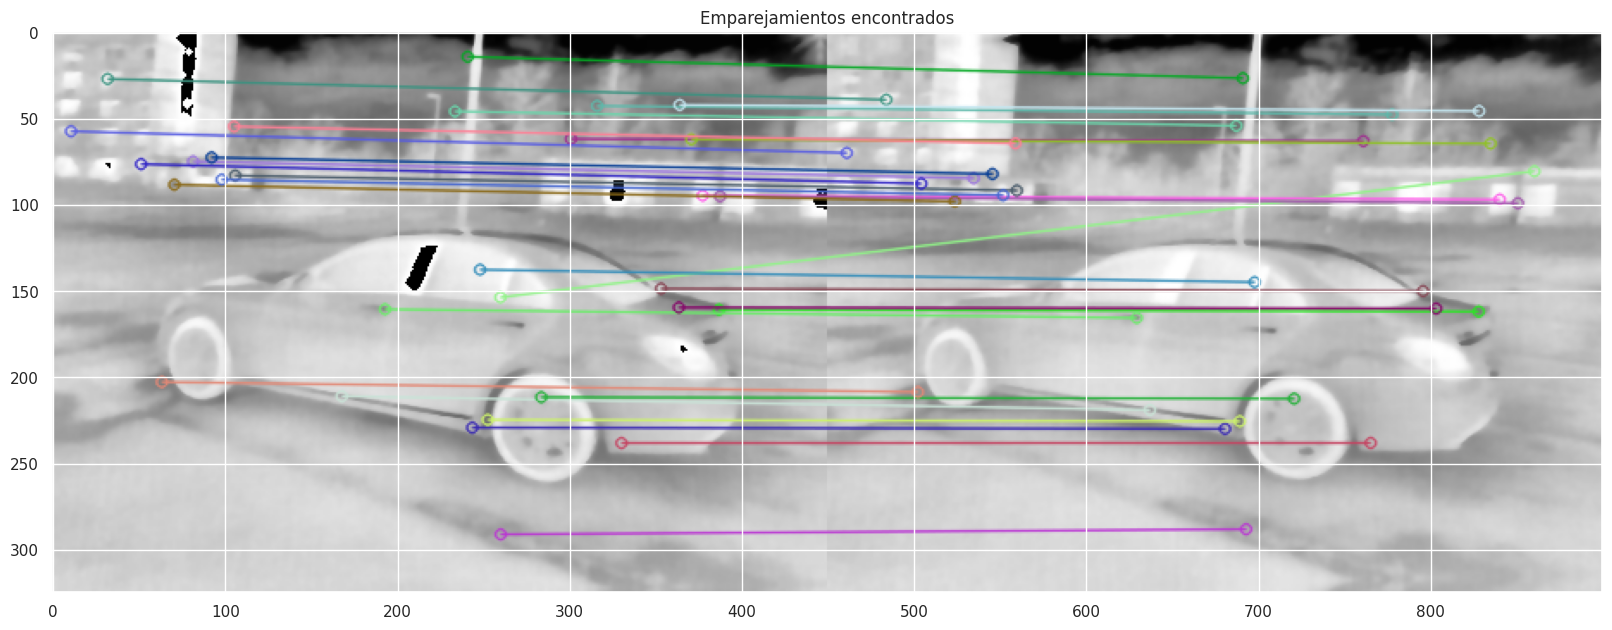

In [578]:
keyPointsLeft, keyPointsRight, ptsLeft, ptsRight, h1, h2, goodMatches = sacar_keypoints(imageL, imageR)
parejas = random.sample(goodMatches,min(30, len(goodMatches)))
imgMatches = cv.drawMatches(imageL, keyPointsLeft, imageR, keyPointsRight, parejas , None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20,10))
plt.imshow(imgMatches)
plt.title("Emparejamientos encontrados")
plt.show()

Número de coincidencias antes del test de ratio: 191
Número de buenas coincidencias después del test de ratio: 87
Image sizes: (325, 450) and (325, 450)


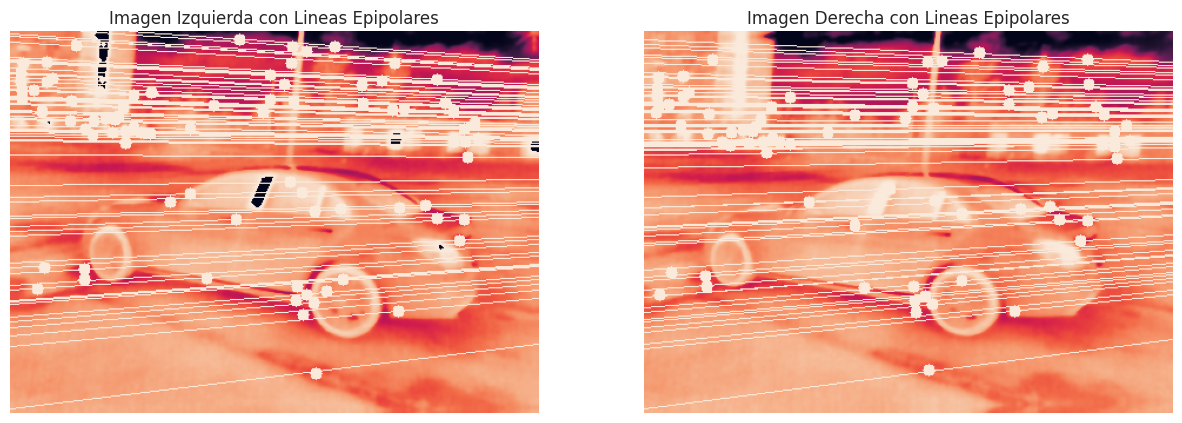

In [579]:
keyPointsLeft, keyPointsRight, ptsLeft, ptsRight, h1, h2, goodMatches = sacar_keypoints(imageL, imageR)
F, mask = cv.findFundamentalMat(ptsLeft, ptsRight, cv.FM_LMEDS)
linesLeft = cv.computeCorrespondEpilines(ptsRight.reshape(-1, 1, 2), 2, F)
linesLeft = linesLeft.reshape(-1, 3)
img5 = drawlines(imageL, imageR, linesLeft, ptsLeft, ptsRight)

linesRight = cv.computeCorrespondEpilines(ptsLeft.reshape(-1, 1, 2), 1, F)
linesRight = linesRight.reshape(-1, 3)
img3 = drawlines(imageR, imageL, linesRight, ptsRight, ptsLeft)

show_images(img5,img3, "Imagen Izquierda con Lineas Epipolares", "Imagen Derecha con Lineas Epipolares")

Image sizes: (325, 450) and (325, 450)


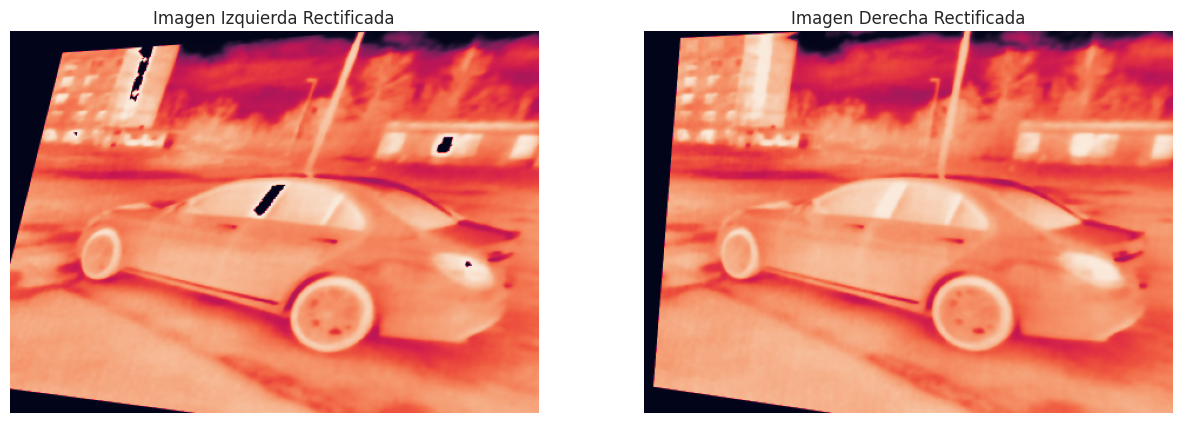

In [580]:
imgLeftRectified = cv.warpPerspective(imageL, h1, (imageL.shape[1], imageL.shape[0]))
imgRightRectified = cv.warpPerspective(imageR, h2, (imageL.shape[1], imageR.shape[0]))
show_images(imgLeftRectified,imgRightRectified, "Imagen Izquierda Rectificada", "Imagen Derecha Rectificada")

Número de coincidencias antes del test de ratio: 190
Número de buenas coincidencias después del test de ratio: 78


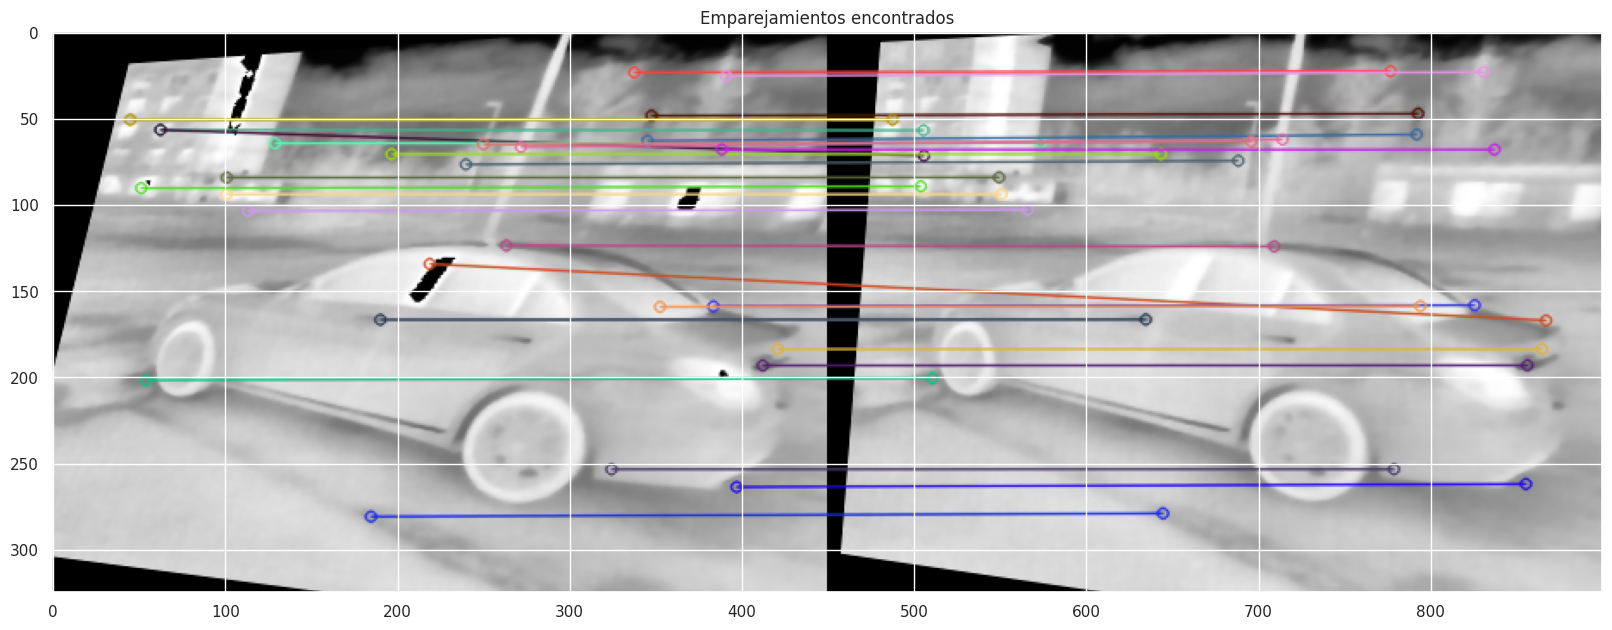

In [603]:
keyPointsLeft, keyPointsRight, ptsLeft, ptsRight, h1, h2, goodMatches = sacar_keypoints(imgLeftRectified, imgRightRectified)
parejas = random.sample(goodMatches,min(30, len(goodMatches)))
imgMatches = cv.drawMatches(imgLeftRectified, keyPointsLeft, imgRightRectified, keyPointsRight, parejas , None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20,10))
plt.imshow(imgMatches)
plt.title("Emparejamientos encontrados")
plt.show()

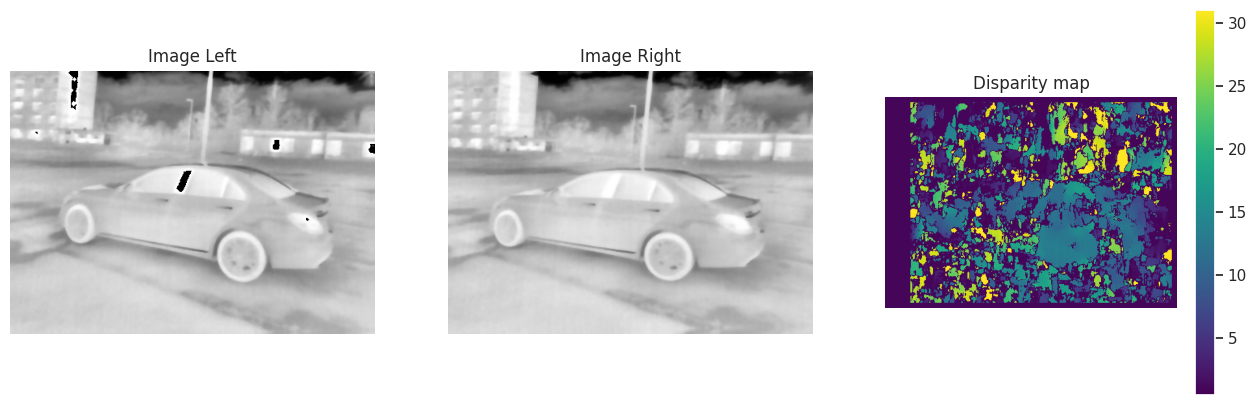

In [582]:
#@title Calculo del mapa de disparidad StereoBM SIN RECTIFICAR
blocksize = 17
stereo = cv.StereoBM_create(numDisparities=32, blockSize=blocksize)
stereo.setPreFilterCap(5)
stereo.setUniquenessRatio(7)
stereo.setSpeckleWindowSize(0)
stereo.setSpeckleRange(0)
stereo.setTextureThreshold(10)

disp_bm_unrectificated = stereo.compute(imageL, imageR).astype(np.float32) / 16.0
plot_disparitymap(imageL, imageR, disp_bm_unrectificated)

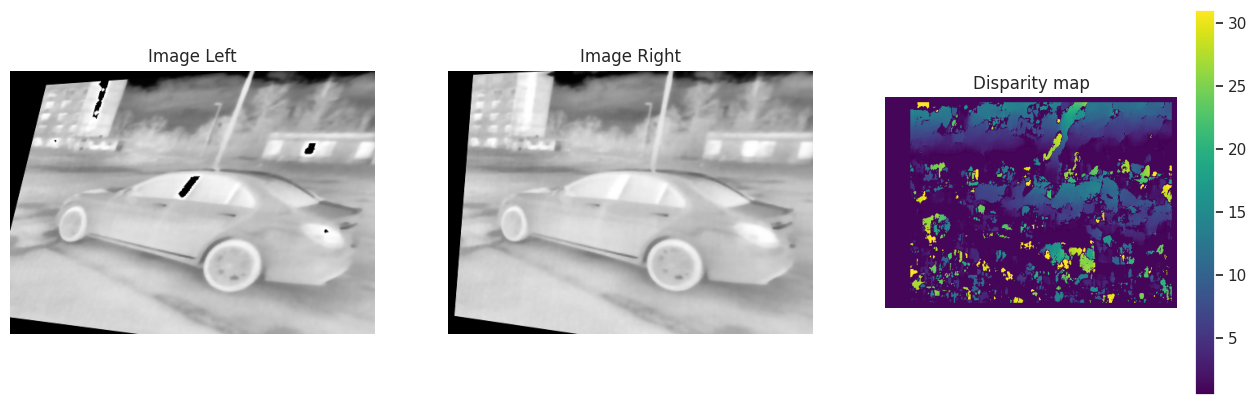

In [583]:
#@title Calculo del mapa de disparidad StereoBM RECTIFICADA
blocksize = 17
stereo = cv.StereoBM_create(numDisparities=32, blockSize=blocksize)
stereo.setPreFilterCap(5)
stereo.setUniquenessRatio(7)
stereo.setSpeckleWindowSize(0)
stereo.setSpeckleRange(0)
stereo.setTextureThreshold(10)

disp_bm = stereo.compute(imgLeftRectified, imgRightRectified).astype(np.float32) / 16.0
plot_disparitymap(imgLeftRectified, imgRightRectified, disp_bm)

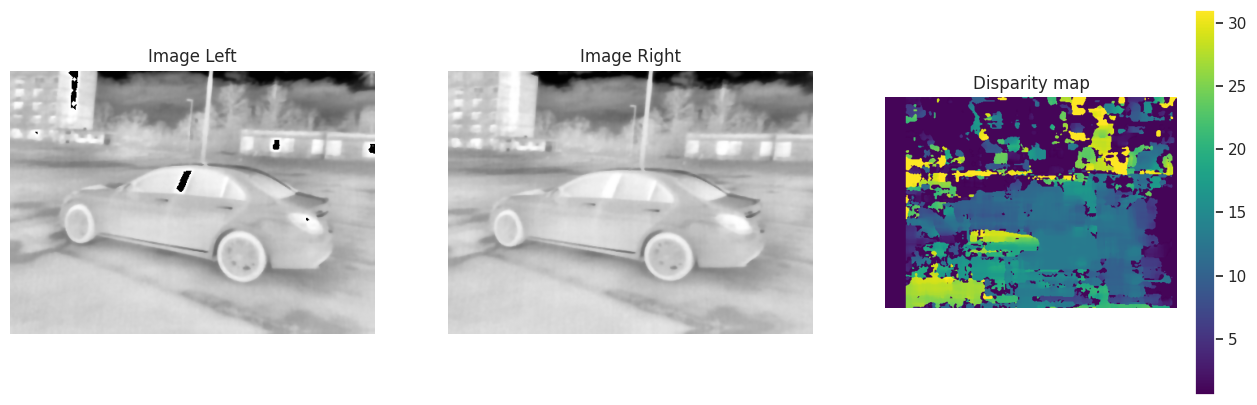

In [584]:
#@title Calculo del mapa de disparidad StereoSGBM SIN RECTIFICAR
blocksize = 13
stereo = cv.StereoSGBM_create(minDisparity=0,
                              numDisparities=32,
                              blockSize=blocksize,
                              P1=8 * 1 * blocksize ** 2,
                              P2=32 * 1 * blocksize ** 2,
                              disp12MaxDiff=1,
                              uniquenessRatio=7,
                              speckleWindowSize=0,
                              speckleRange=0,
                              preFilterCap=5,
                              mode=cv.STEREO_SGBM_MODE_SGBM_3WAY
                              )
disp_sgbm_unrectificated = stereo.compute(imageL, imageR).astype(np.float32) / 16.0
plot_disparitymap(imageL, imageR, disp_sgbm_unrectificated)

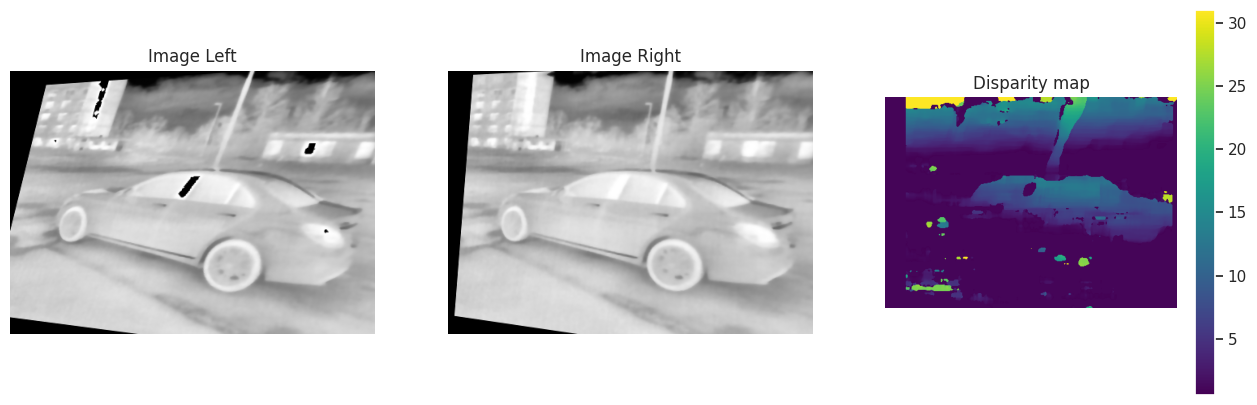

In [585]:
#@title Calculo del mapa de disparidad StereoSGBM RECTIFICADA
blocksize = 13
stereo = cv.StereoSGBM_create(minDisparity=0,
                              numDisparities=32,
                              blockSize=blocksize,
                              P1=8 * 1 * blocksize ** 2,
                              P2=32 * 1 * blocksize ** 2,
                              disp12MaxDiff=1,
                              uniquenessRatio=7,
                              speckleWindowSize=0,
                              speckleRange=0,
                              preFilterCap=5,
                              mode=cv.STEREO_SGBM_MODE_SGBM_3WAY
                              )
disp_sgbm = stereo.compute(imgLeftRectified, imgRightRectified).astype(np.float32) / 16.0
plot_disparitymap(imgLeftRectified, imgRightRectified, disp_sgbm)

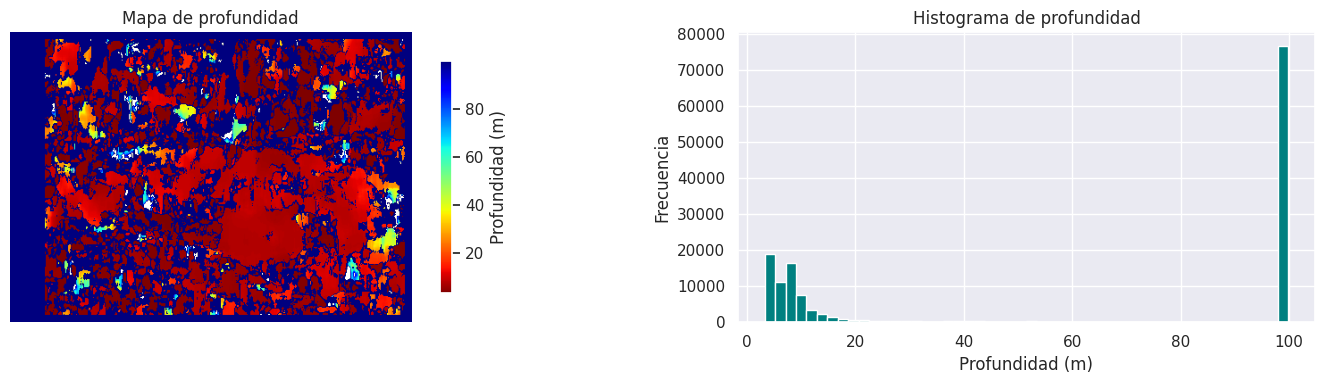

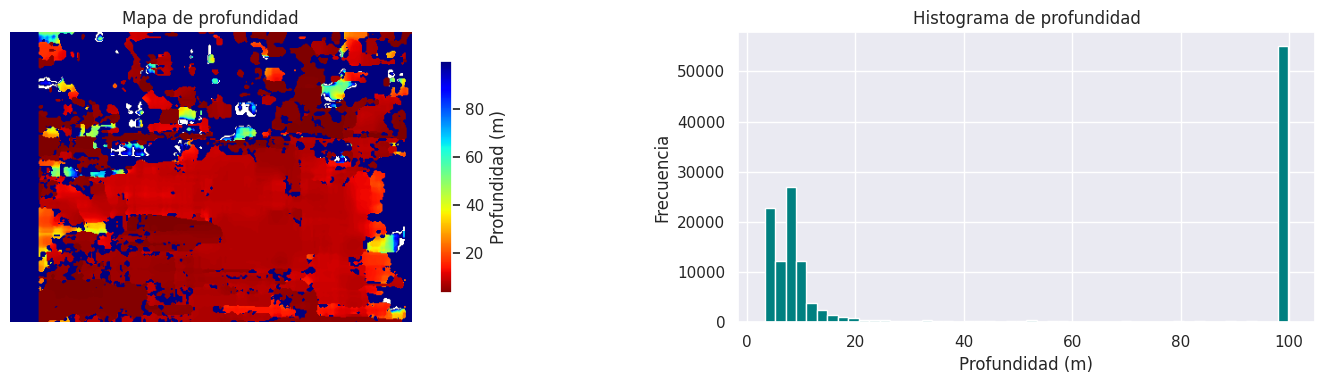

In [586]:
#@title calculo del mapa de profundidad SIN RECTIFICAR
f = 406.33233091474426 # Distancia focal en pixeles
baseline = 0.24584925266278748 # Separacion entre las camaras en metros

# StereoBM
depth_bm_calc_unrectificated = (f * baseline) / (disp_bm_unrectificated + 1e-6)
plot_depth_map(depth_bm_calc_unrectificated, umbral=100)

# StereoSGBM
depth_sgbm_calc_unrectificated = (f * baseline) / (disp_sgbm_unrectificated + 1e-6)
plot_depth_map(depth_sgbm_calc_unrectificated, umbral=100)

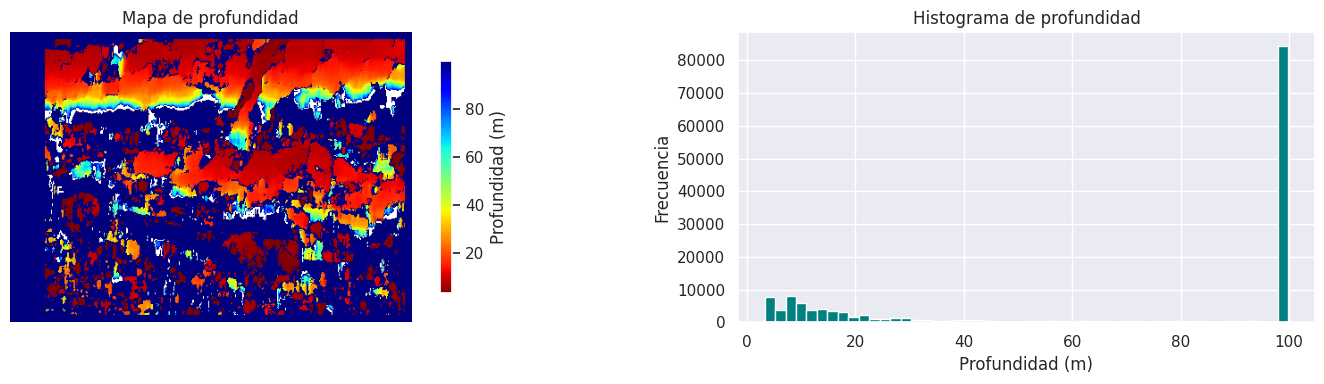

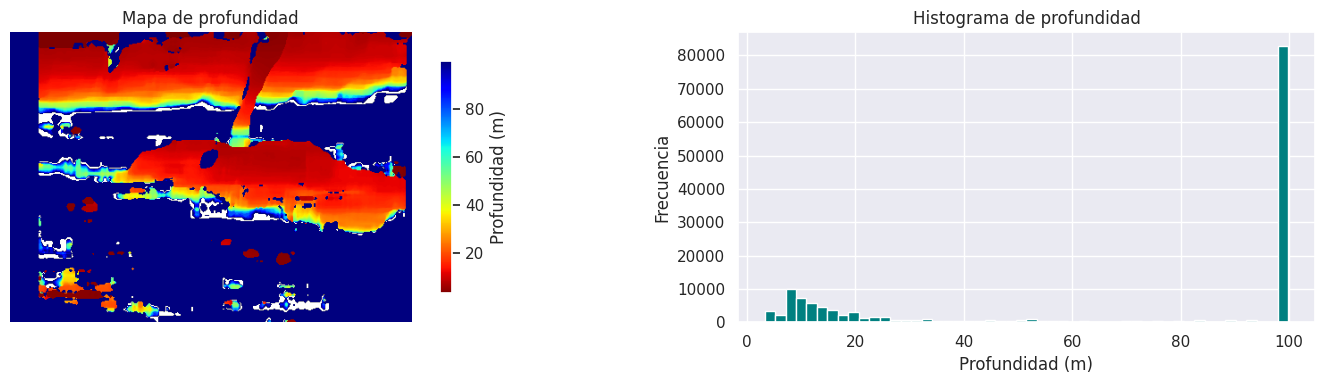

In [587]:
#@title calculo del mapa de profundidad RECTIFICADA
f = 406.33233091474426 # Distancia focal en pixeles
baseline = 0.24584925266278748 # Separacion entre las camaras en metros

# StereoBM
depth_bm_calc = (f * baseline) / (disp_bm + 1e-6)
plot_depth_map(depth_bm_calc, umbral=100)

# StereoSGBM
depth_sgbm_calc = (f * baseline) / (disp_sgbm + 1e-6)
plot_depth_map(depth_sgbm_calc, umbral=100)

In [588]:
#@title Caracteristicas del mapa de pronfidad calculado SIN RECTIFICAR
print('--'*30)
print("Mapa de profundida StereoBM")
print('Profundidad de Bits: ', depth_bm_calc_unrectificated.dtype)
print("Valor maximo = ", depth_bm_calc_unrectificated.max(), "Valor minimo = ", depth_bm_calc_unrectificated.min())
print("Valor promedio =  ", np.mean(depth_bm_calc_unrectificated))
print('Tamaño: ', depth_bm_calc_unrectificated.shape)
print('--'*30)
print("Mapa de profundida StereoSGBM")
print('Profundidad de Bits: ', depth_sgbm_calc.dtype)
print("Valor maximo = ", depth_sgbm_calc.max(), "Valor minimo = ", depth_sgbm_calc.min())
print("Valor promedio =  ", np.mean(depth_sgbm_calc))
print('Tamaño: ', depth_sgbm_calc.shape)
print('--'*30)

------------------------------------------------------------
Mapa de profundida StereoBM
Profundidad de Bits:  float32
Valor maximo =  199.79259 Valor minimo =  3.2224674
Valor promedio =   58.208492
Tamaño:  (325, 450)
------------------------------------------------------------
Mapa de profundida StereoSGBM
Profundidad de Bits:  float32
Valor maximo =  177.59346 Valor minimo =  3.2224674
Valor promedio =   69.07076
Tamaño:  (325, 450)
------------------------------------------------------------


In [589]:
#@title Caracteristicas del mapa de pronfidad calculado RECTIFICADA
print('--'*30)
print("Mapa de profundida StereoBM")
print('Profundidad de Bits: ', depth_bm_calc.dtype)
print("Valor maximo = ", depth_bm_calc.max(), "Valor minimo = ", depth_bm_calc.min())
print("Valor promedio =  ", np.mean(depth_bm_calc))
print('Tamaño: ', depth_bm_calc.shape)
print('--'*30)
print("Mapa de profundida StereoSGBM")
print('Profundidad de Bits: ', depth_sgbm_calc.dtype)
print("Valor maximo = ", depth_sgbm_calc.max(), "Valor minimo = ", depth_sgbm_calc.min())
print("Valor promedio =  ", np.mean(depth_sgbm_calc))
print('Tamaño: ', depth_sgbm_calc.shape)
print('--'*30)

------------------------------------------------------------
Mapa de profundida StereoBM
Profundidad de Bits:  float32
Valor maximo =  199.79259 Valor minimo =  3.2224674
Valor promedio =   69.02011
Tamaño:  (325, 450)
------------------------------------------------------------
Mapa de profundida StereoSGBM
Profundidad de Bits:  float32
Valor maximo =  177.59346 Valor minimo =  3.2224674
Valor promedio =   69.07076
Tamaño:  (325, 450)
------------------------------------------------------------


In [590]:
def mae_percentage(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mae = np.mean(np.abs(y_true - y_pred))
    return (mae / np.mean(y_true)) * 100

def rmse_percentage(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return (rmse / np.mean(y_true)) * 100

------------------------------------------------------------
Errores StereoBM
MAE = 148.07385982905984
RMSE = 165.47713549118714
------------------------------------------------------------
Errores StereoSGBM
MAE = 165.4776205128205
RMSE = 183.0579916672456
------------------------------------------------------------


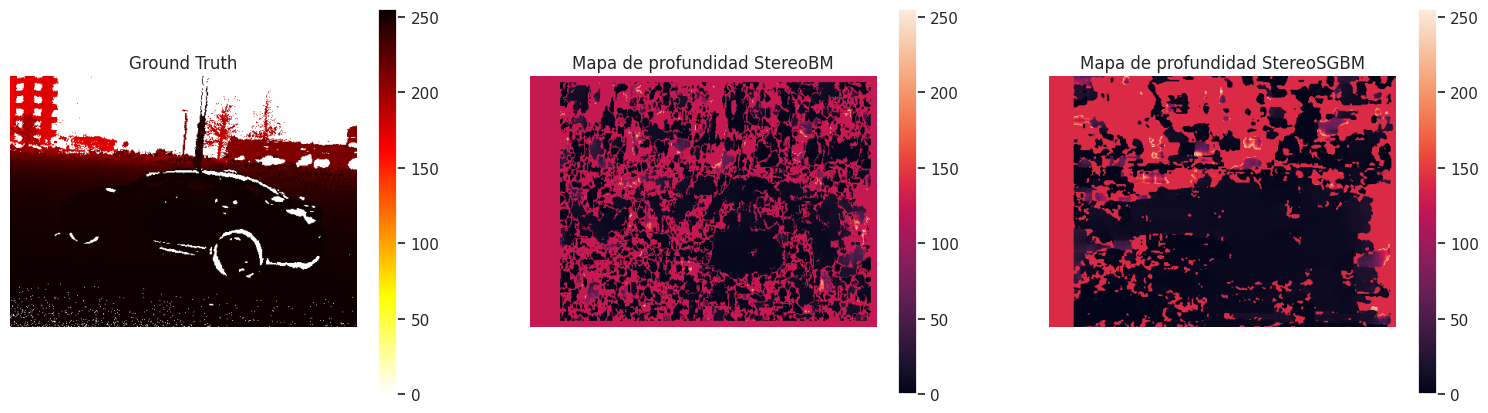

In [591]:
#@title Comparación entre el depth calculado y el ground truth SIN RECTIFICAR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error

# Normalizar el depth calculado y pasarlo a uint8
depth_bm_calc_un = normalize(depth_bm_calc_unrectificated)
depth_sgbm_calc_un = normalize(depth_sgbm_calc_unrectificated)

# Normalizar el ground truth y pasarlo a uint8
ground_truth = normalize(depth)

# Calculo de errores
mae_bm = mean_absolute_error(ground_truth, depth_bm_calc_un)
rmse_bm = root_mean_squared_error(ground_truth, depth_bm_calc_un)
mae_sgbm = mean_absolute_error(ground_truth, depth_sgbm_calc_un)
rmse_sgbm = root_mean_squared_error(ground_truth, depth_sgbm_calc_un)

print('--'*30)
print('Errores StereoBM')
print(f'MAE = {mae_bm}')
print(f'RMSE = {rmse_bm}')
print('--'*30)
print('Errores StereoSGBM')
print(f'MAE = {mae_sgbm}')
print(f'RMSE = {rmse_sgbm}')
print('--'*30)

plt.figure(figsize=(19,5))
plt.subplot(131)
plt.imshow(ground_truth, cmap='hot_r')
plt.title('Ground Truth')
plt.colorbar()
plt.axis('off')
plt.subplot(132)
plt.imshow(depth_bm_calc_un)
plt.title('Mapa de profundidad StereoBM')
plt.colorbar()
plt.axis('off')
plt.subplot(133)
plt.imshow(depth_sgbm_calc_un)
plt.title('Mapa de profundidad StereoSGBM')
plt.colorbar()
plt.axis('off')
plt.show()

------------------------------------------------------------
Errores StereoBM
MAE = 127.12967521367521
RMSE = 143.75283195820833
------------------------------------------------------------
Errores StereoSGBM
MAE = 109.55079658119658
RMSE = 127.71928900703175
------------------------------------------------------------


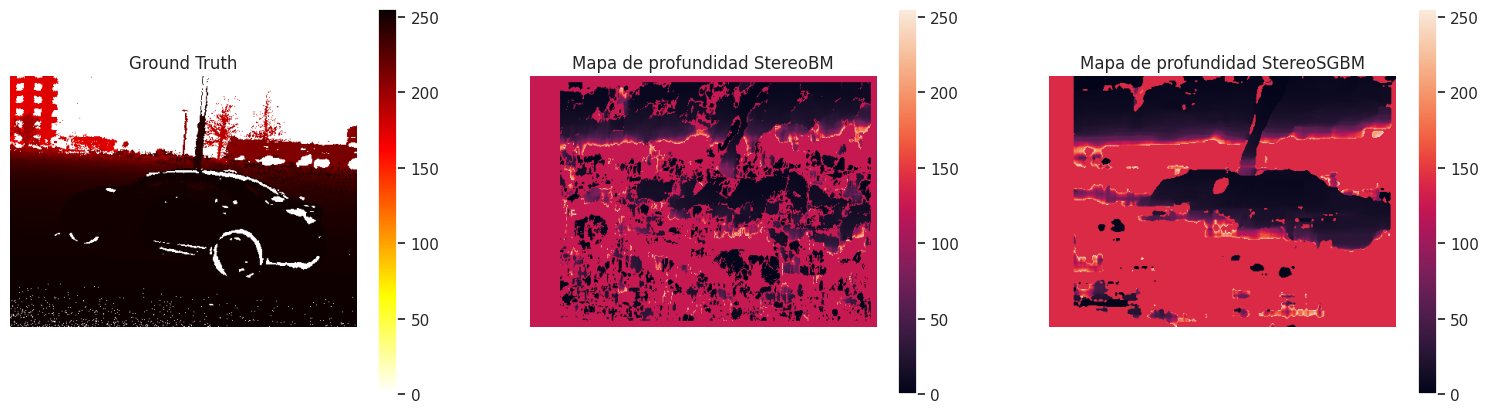

In [592]:
#@title Comparación entre el depth calculado y el ground truth RECTIFICADA

# Normalizar el depth calculado y pasarlo a uint8
depth_bm_calc = normalize(depth_bm_calc)
depth_sgbm_calc = normalize(depth_sgbm_calc)

# Normalizar el ground truth y pasarlo a uint8
ground_truth = normalize(depth)

# Calculo de errores
mae_bm = mean_absolute_error(ground_truth, depth_bm_calc)
rmse_bm = root_mean_squared_error(ground_truth, depth_bm_calc)
mae_sgbm = mean_absolute_error(ground_truth, depth_sgbm_calc)
rmse_sgbm = root_mean_squared_error(ground_truth, depth_sgbm_calc)

print('--'*30)
print('Errores StereoBM')
print(f'MAE = {mae_bm}')
print(f'RMSE = {rmse_bm}')
print('--'*30)
print('Errores StereoSGBM')
print(f'MAE = {mae_sgbm}')
print(f'RMSE = {rmse_sgbm}')
print('--'*30)

plt.figure(figsize=(19,5))
plt.subplot(131)
plt.imshow(ground_truth, cmap='hot_r')
plt.title('Ground Truth')
plt.colorbar()
plt.axis('off')
plt.subplot(132)
plt.imshow(depth_bm_calc)
plt.title('Mapa de profundidad StereoBM')
plt.colorbar()
plt.axis('off')
plt.subplot(133)
plt.imshow(depth_sgbm_calc)
plt.title('Mapa de profundidad StereoSGBM')
plt.colorbar()
plt.axis('off')
plt.show()